In [14]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # Updated import path
from sklearn.model_selection import train_test_split

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load the CSV and generate additional features

In [16]:
def Generate_new_feature_in_csv(input=None):
    '''Generate new feature, Mapping the output feature'''
    if input is None:
        input = "/content/drive/MyDrive/CV-Folder/Projects/Diabethic-Retinopathy[Major]/train.csv"
    data = pd.read_csv(input)
    Defect_binary = {
        0: 'No_DR',
        1: 'DR',
        2: 'DR',
        3: 'DR',
        4: 'DR'}
    diagnosis_all_dict = {0: 'No_DR', 1: 'Mild', 2: 'Moderate', 3: 'Severe', 4: 'Proliferate_DR'}
    data['binary_type'] = data['diagnosis'].map(Defect_binary.get)
    data['type'] = data['diagnosis'].map(diagnosis_all_dict.get)
    return data

# Split the data

In [17]:
def data_separation():
    data = Generate_new_feature_in_csv()
    train, val = train_test_split(data, test_size=0.2, stratify=data['type'])
    train, test = train_test_split(train, test_size=0.15 / (1 - 0.15), stratify=train['type'])
    return train, val, test

# Separate the images into respective directories

In [18]:
import os
import shutil

def mkdir_separate_image():
    train, val, test = data_separation()  # Assume data_separation() returns train, val, test dataframes

    base_dir = '/content'  # Define your base directory path here
    train_dir = os.path.join(base_dir, 'train')
    val_dir = os.path.join(base_dir, 'val')
    test_dir = os.path.join(base_dir, 'test')

    # Create train, val, test directories if they do not exist
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    src_dir = '/content/drive/MyDrive/CV-Folder/Projects/Diabethic-Retinopathy[Major]/gaussian_filtered_images'

    # Helper function to copy files based on dataset type
    def copy_files(data, dest_dir):
        for index, row in data.iterrows():
            diagnosis = row['type']
            binary_diagnosis = row['binary_type']
            id_code = row['id_code'] + ".png"
            srcfile = os.path.join(src_dir, diagnosis, id_code)
            dst_dir = os.path.join(dest_dir, binary_diagnosis)
            os.makedirs(dst_dir, exist_ok=True)
            shutil.copy(srcfile, dst_dir)

    # Copy files to train, val, and test directories
    copy_files(train, train_dir)
    copy_files(val, val_dir)
    copy_files(test, test_dir)

mkdir_separate_image()

# Load images using ImageDataGenerator


In [19]:
# Load images using ImageDataGenerator
def ImageDataGenerator_Data():
    train_dir = 'train'
    val_dir = 'val'
    test_dir = 'test'

    train_batches = ImageDataGenerator(rescale=1/255.).flow_from_directory(train_dir, target_size=(224,224), shuffle=True)
    val_batches = ImageDataGenerator(rescale=1/255.).flow_from_directory(val_dir, target_size=(224,224), shuffle=True)
    test_batches = ImageDataGenerator(rescale=1/255.).flow_from_directory(test_dir, target_size=(224,224), shuffle=True)

    return train_batches, val_batches, test_batches

# Initialize train, validation, and test batches
train_batches, val_batches, test_batches = ImageDataGenerator_Data()


Found 3522 images belonging to 2 classes.
Found 1776 images belonging to 2 classes.
Found 1351 images belonging to 2 classes.


#CNN Model

In [20]:
import tensorflow as tf
from tensorflow.keras import layers

# Define CNN model
def CNN_Model():
    model = tf.keras.Sequential([
        layers.Conv2D(8, (3,3), activation='relu', input_shape=(224, 224, 3)),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.BatchNormalization(),

        layers.Conv2D(16, (3,3), activation='relu'),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.BatchNormalization(),

        layers.Conv2D(32, (3,3), activation='relu'),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.BatchNormalization(),

        layers.Flatten(),
        layers.Dense(32, activation='relu'),
        layers.Dropout(0.15),
        layers.Dense(2, activation='softmax')
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
                  loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Train CNN model
cnn_model = CNN_Model()

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)
history = cnn_model.fit(train_batches, validation_data=val_batches, epochs=10, callbacks=[es])

# Evaluate CNN model
cnn_loss, cnn_acc = cnn_model.evaluate(test_batches)
print(f"CNN Test Accuracy: {cnn_acc:.4f}, Loss: {cnn_loss:.4f}")

# Save model
cnn_model.save('final_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


111/111 ━━━━━━━━━━━━━━━━━━━━ 33s 219ms/step - accuracy: 0.7782 - loss: 0.4948 - val_accuracy: 0.5023 - val_loss: 0.7186
Epoch 2/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 15s 129ms/step - accuracy: 0.9127 - loss: 0.2449 - val_accuracy: 0.6014 - val_loss: 0.6303
Epoch 3/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 15s 131ms/step - accuracy: 0.9304 - loss: 0.2027 - val_accuracy: 0.7016 - val_loss: 0.4607
Epoch 4/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 15s 133ms/step - accuracy: 0.9351 - loss: 0.1846 - val_accuracy: 0.8896 - val_loss: 0.3040
Epoch 5/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 20s 125ms/step - accuracy: 0.9432 - loss: 0.1691 - val_accuracy: 0.9364 - val_loss: 0.2002
Epoch 6/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 15s 128ms/step - accuracy: 0.9435 - loss: 0.1682 - val_accuracy: 0.9414 - val_loss: 0.1652
Epoch 7/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 20s 128ms/step - accuracy: 0.9468 - loss: 0.1551 - val_accuracy: 0.9505 - val_loss: 0.1521
Epoch 8/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 15s 128ms/step - accuracy: 0.9480 - loss: 0.1569 - val

CNN Test Accuracy: 0.9563, Loss: 0.1288


#Upload Image to Test the Trained CNN Model

Saving 4c52922f3bfd.png to 4c52922f3bfd.png


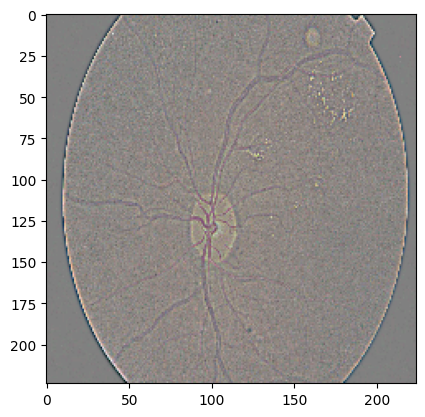

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step
Prediction: DR (Diabetic Retinopathy)


In [21]:
import cv2
import tensorflow as tf
from google.colab import files
import numpy as np
from matplotlib import pyplot as plt

# Function to upload image and predict using the CNN model
def upload_and_predict():
    uploaded = files.upload()

    for fn in uploaded.keys():
        # Load the image
        img = cv2.imread(fn)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_resized = cv2.resize(img_rgb, (224, 224))
        plt.imshow(img_resized)
        plt.show()

        # Preprocess the image
        img_array = np.array(img_resized) / 255.0  # Normalize
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

        # Load the saved CNN model
        model = tf.keras.models.load_model('final_model.h5')

        # Make prediction
        prediction = model.predict(img_array)
        predicted_class = np.argmax(prediction)

        # Output the result
        if predicted_class == 0:
            print('Prediction: DR (Diabetic Retinopathy)')
        else:
            print('Prediction: No DR (No Diabetic Retinopathy)')

# Test the model with an uploaded image
upload_and_predict()


#Random Forest and SVM Model

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

# Function to extract and resize image data
def extract_data(batch, sample_size=500, image_size=(112, 112)):  # Resize to a smaller size
    data = []
    labels = []
    count = 0

    for images, label in batch:
        for i, img in enumerate(images):
            if count >= sample_size:
                break
            # Resize image and normalize, then convert to float16 to save memory
            resized_img = tf.image.resize(img, image_size).numpy().flatten().astype('float16')
            data.append(resized_img)
            labels.append(label[i])
            count += 1

        if count >= sample_size:
            break

    return np.array(data), np.array(labels)

# Limit the number of samples for training and testing
train_data, train_labels = extract_data(train_batches, sample_size=500)
val_data, val_labels = extract_data(val_batches, sample_size=100)
test_data, test_labels = extract_data(test_batches, sample_size=100)

# Random Forest Classifier with memory optimizations
rf_model = RandomForestClassifier(n_estimators=50, max_depth=10, random_state=42)
rf_model.fit(train_data, train_labels)

# Evaluate on validation data
rf_val_preds = rf_model.predict(val_data)
rf_val_acc = accuracy_score(val_labels, rf_val_preds)
print(f'Random Forest Validation Accuracy: {rf_val_acc:.4f}')

# Evaluate on test data
rf_test_preds = rf_model.predict(test_data)
rf_test_acc = accuracy_score(test_labels, rf_test_preds)
print(f'Random Forest Test Accuracy: {rf_test_acc:.4f}')

Random Forest Validation Accuracy: 0.9100
Random Forest Test Accuracy: 0.9400


#Upload Image to Test the Trained Random Forest and SVM Model

In [ ]:
# import cv2
# import numpy as np
# from google.colab import files
# from matplotlib import pyplot as plt

# # Function to upload an image, preprocess it, and predict using the Random Forest model
# def upload_and_predict_rf(rf_model, image_size=(112, 112)):
#     # Upload image using Colab's file upload utility
#     uploaded = files.upload()

#     for fn in uploaded.keys():
#         # Read the image using cv2
#         img = cv2.imread(fn)
#         img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB for consistency
#         img_resized = cv2.resize(img_rgb, image_size)  # Resize the image to the expected input size

#         plt.imshow(img_resized)
#         plt.title("Uploaded Image")
#         plt.show()

#         # Preprocess the image for the model
#         img_array = img_resized.flatten().astype('float16') / 255.0  # Flatten and normalize
#         img_array = img_array.reshape(1, -1)  # Reshape to 1D array as input for the model

#         # Make prediction using the Random Forest model
#         prediction = rf_model.predict_proba(img_array)  # Get probability predictions

#         # Print the prediction to understand its structure
#         print("Raw prediction output:", prediction)

#         # Extract the predicted class using np.argmax()
#         predicted_class = np.argmax(prediction[0])  # Find the class index with the highest probability

#         # Output the result based on label encoding
#         if predicted_class == 0:  # Adjust according to your label encoding
#             print('Prediction: DR (Diabetic Retinopathy)')
#         else:
#             print('Prediction: No DR (No Diabetic Retinopathy)')

# # Call the function with your trained Random Forest model
# upload_and_predict_rf(rf_model)
